In [3]:
import os
import gzip
import shutil
import wget
import numpy as np
import matplotlib.pyplot as plt
import time

/home/megamax625/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### MNIST

In [4]:
def download_mnist():
    if not os.path.exists("train-images-idx3-ubyte.gz"):
        wget.download("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
        wget.download("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")
        wget.download("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")
        wget.download("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")

    with gzip.open("train-images-idx3-ubyte.gz", "rb") as f_in, open("train-images-idx3-ubyte", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    with gzip.open("train-labels-idx1-ubyte.gz", "rb") as f_in, open("train-labels-idx1-ubyte", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    with gzip.open("t10k-images-idx3-ubyte.gz", "rb") as f_in, open("t10k-images-idx3-ubyte", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    with gzip.open("t10k-labels-idx1-ubyte.gz", "rb") as f_in, open("t10k-labels-idx1-ubyte", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

def load_mnist(dtype=np.float32, as_categorical=False):
    train_images_path = "train-images-idx3-ubyte"
    train_labels_path = "train-labels-idx1-ubyte"
    test_images_path = "t10k-images-idx3-ubyte"
    test_labels_path = "t10k-labels-idx1-ubyte"

    with open(train_images_path, "rb") as f:
        X_train = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 784).astype(dtype)

    with open(train_labels_path, "rb") as f:
        y_train = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

    with open(test_images_path, "rb") as f:
        X_test = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 784).astype(dtype)

    with open(test_labels_path, "rb") as f:
        y_test = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

    if as_categorical:
        y_train = np.eye(10)[y_train]
        y_test = np.eye(10)[y_test]

    return (X_train, y_train), (X_test, y_test)

### Activation functions

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def der_sigmoid(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def der_relu(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### MLP

In [4]:
class MLP:   
    def __init__(self, input_size, layer_sizes, output_size, activation_function='sigmoid', batch_size=256):
        self.layers_sizes = [input_size] + layer_sizes + [output_size]
        self.batch_size = batch_size
        self.loss_function = 'CE'
        self.weights = [np.random.randn(self.layers_sizes[i], self.layers_sizes[i+1]) / np.sqrt(self.layers_sizes[i])
                    for i in range(len(self.layers_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in self.layers_sizes[1:]]
        self.params = [p for pair in zip(self.weights, self.biases) for p in pair]
        self.activations = []
        self.prev_updates = None
        self.m = None
        self.v = None

        self.activation_function = activation_function
        self.adagrad_G = [np.zeros_like(param) for param in self.params]

    def forward(self, X):
        activations = [X]
        prev_activations = []
        for W, b in zip(self.weights, self.biases):
            Z = np.dot(activations[-1], W) + b
            prev_activations.append(Z)
            if W is not self.weights[-1]:
                if self.activation_function == 'sigmoid':
                    A = sigmoid(Z)
                elif self.activation_function == 'relu':
                    A = relu(Z)
            else:
                A = softmax(Z)
            activations.append(A)

        self.activations = activations
        self.prev_activations = prev_activations

    def get_grad_and_loss(self, X, y):
        m = X.shape[0]
        gradients = [0] * len(self.params)
        clipped_A = np.clip(self.activations[-1], 1e-8, 1.0 - 1e-8)
        clipped_y = np.clip(y, 1e-10, 1.0 - 1e-10)

        if self.loss_function == 'CE':
            loss = -np.mean(clipped_y * np.log(clipped_A))
        elif self.loss_function == 'KLD':
            loss = np.sum(clipped_y * np.log(clipped_y / clipped_A), axis=1).mean()
        elif self.loss_function == 'MSE':
            loss = np.mean((y - self.activations[-1]) ** 2)

        delta = self.activations[-1] - y
        gradients[-1] = (1 / m) * np.sum(delta, axis=0, keepdims=True)
        gradients[-2] = (1 / m) * np.dot(self.activations[-2].T, delta)

        for i in range(len(self.layers_sizes) - 3, -1, -1):
            if self.activation_function == 'sigmoid':
                delta = np.dot(delta, self.weights[i+1].T) * der_sigmoid(self.activations[i+1])
            elif self.activation_function == 'relu':
                delta = np.dot(delta, self.weights[i+1].T) * der_relu(self.activations[i+1])

            gradients[2*i] = (1 / m) * np.dot(self.activations[i].T, delta)
            gradients[2*i + 1] = (1 / m) * np.sum(delta, axis=0, keepdims=True)

        return gradients, loss
    
    def sgd(self, gradients):
        for i, g in enumerate(gradients):
            self.params[i] -= self.learning_rate * g

    def nag(self, gradients):
        momentums = [0] * len(self.params)
        if self.prev_updates is not None:
            for i in range(len(self.params)):
                momentums[i] = 0.9*self.prev_updates[i] + self.learning_rate * gradients[i]
                self.params[i] -= momentums[i]
        else:
            for i, g in enumerate(gradients):
                momentums[i] = self.learning_rate * g
                self.params[i] -= momentums[i]
        self.prev_updates = momentums.copy()

    def adagrad(self, gradients, epsilon=1e-8):
        for i, g in enumerate(gradients):
            self.adagrad_G[i] += g * g
            self.params[i] -= self.learning_rate * g / (np.sqrt(self.adagrad_G[i]) + epsilon)
            
    def adam(self, gradients, t):
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8

        if self.m is None:
            self.m = [np.zeros_like(p) for p in self.params]
        if self.v is None:
            self.v = [np.zeros_like(p) for p in self.params]

        for i, (m, v, g) in enumerate(zip(self.m, self.v, gradients)):
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * g * g

            m_cap = m / (1 - beta1 ** t)
            v_cap = v / (1 - beta2 ** t)

            self.params[i] -= (self.learning_rate / (np.sqrt(v_cap) + epsilon)) * m_cap

            self.m[i] = m
            self.v[i] = v        

    def fit(self, X, y, optimization_method='SGD', debug=True, epochs=150, lr=0.05):
        self.optimization_method = optimization_method
        self.losses = []
        self.learning_rate = lr
        num_batches = X.shape[0] // self.batch_size
        for i in range(epochs):
            epoch_start_time = time.time()
            epoch_loss = 0
            for batch_index in range(num_batches):
                start = batch_index * self.batch_size
                end = (batch_index + 1) * self.batch_size

                X_batch = X[start:end, :]
                y_batch = y[start:end, :]

                self.forward(X_batch)
                gradients, loss = self.get_grad_and_loss(X_batch, y_batch)
                if self.optimization_method == 'SGD':
                    self.sgd(gradients)
                elif self.optimization_method == 'NAG':
                    self.nag(gradients)
                elif self.optimization_method == 'Adagrad':
                    self.adagrad(gradients)
                elif self.optimization_method == 'Adam':
                    self.adam(gradients, i + 1)
                epoch_loss += loss

            epoch_loss /= num_batches
                
            if debug:
                print(f"Epoch №{i + 1}, loss: {epoch_loss}, time spent: {time.time() - epoch_start_time:.2f}s")
            self.losses.append(epoch_loss)

    def predict(self, X):
        self.forward(X)
        return np.argmax(self.activations[-1], axis=1)

    def predict_logits(self, X):
        self.forward(X)
        return self.activations[-1]

### Train

In [8]:
(X_train, y_train), (X_test, y_test) = load_mnist(dtype=np.float32, as_categorical=True)

X_train /= 255
X_test /= 255

In [6]:
mlp_sgd = MLP(input_size=784, layer_sizes=[64, 64], output_size=10, batch_size=32)
mlp_sgd.fit(X_train, y_train, optimization_method='SGD', epochs=20)

Epoch №1, loss: 0.1446373653057512, time spent: 2.78s
Epoch №2, loss: 0.052425300022487194, time spent: 1.61s
Epoch №3, loss: 0.03829996320933972, time spent: 2.84s
Epoch №4, loss: 0.03259571351610797, time spent: 1.79s
Epoch №5, loss: 0.028962239238404176, time spent: 1.74s
Epoch №6, loss: 0.026167573540613723, time spent: 1.76s
Epoch №7, loss: 0.023850145261605005, time spent: 1.64s
Epoch №8, loss: 0.021876500924061806, time spent: 1.83s
Epoch №9, loss: 0.02018179134665078, time spent: 1.73s
Epoch №10, loss: 0.018719740355913634, time spent: 1.64s
Epoch №11, loss: 0.017450334553615585, time spent: 1.61s
Epoch №12, loss: 0.016339290403624012, time spent: 3.96s
Epoch №13, loss: 0.01535891995482139, time spent: 3.60s
Epoch №14, loss: 0.014487431858351506, time spent: 4.22s
Epoch №15, loss: 0.013707592436019373, time spent: 4.11s
Epoch №16, loss: 0.013005639635648493, time spent: 3.61s
Epoch №17, loss: 0.012370410558940757, time spent: 1.77s
Epoch №18, loss: 0.011792647774241292, time sp

In [7]:
mlp_nag = MLP(input_size=784, layer_sizes=[64, 64], output_size=10, batch_size=32)
mlp_nag.fit(X_train, y_train, optimization_method='NAG', epochs=20)

Epoch №1, loss: 0.048122507389613475, time spent: 2.25s
Epoch №2, loss: 0.01861847938652207, time spent: 4.38s
Epoch №3, loss: 0.013132513964533713, time spent: 2.98s
Epoch №4, loss: 0.010303141786986448, time spent: 2.11s
Epoch №5, loss: 0.00852315061238843, time spent: 3.30s
Epoch №6, loss: 0.007247021554570612, time spent: 2.43s
Epoch №7, loss: 0.006229060385370783, time spent: 1.92s
Epoch №8, loss: 0.005348886278795014, time spent: 2.25s
Epoch №9, loss: 0.004582166163670898, time spent: 2.03s
Epoch №10, loss: 0.003926721874298, time spent: 2.16s
Epoch №11, loss: 0.0033677217202131024, time spent: 1.89s
Epoch №12, loss: 0.0028864091122718853, time spent: 2.30s
Epoch №13, loss: 0.002474676807297721, time spent: 2.54s
Epoch №14, loss: 0.0021146773117893458, time spent: 4.75s
Epoch №15, loss: 0.0017995917860215134, time spent: 4.83s
Epoch №16, loss: 0.0015291191814635985, time spent: 2.86s
Epoch №17, loss: 0.0013125568056637708, time spent: 2.77s
Epoch №18, loss: 0.0011372663455338878,

In [8]:
mlp_adagrad = MLP(input_size=784, layer_sizes=[64, 64], output_size=10, batch_size=32)
mlp_adagrad.fit(X_train, y_train, optimization_method='Adagrad', epochs=20)

Epoch №1, loss: 0.02584478047143922, time spent: 5.65s
Epoch №2, loss: 0.01360446635647952, time spent: 7.48s
Epoch №3, loss: 0.010761117397984262, time spent: 4.35s
Epoch №4, loss: 0.009095117179405124, time spent: 4.23s
Epoch №5, loss: 0.007954979122802141, time spent: 3.30s
Epoch №6, loss: 0.007099906578016096, time spent: 3.41s
Epoch №7, loss: 0.006418239312071164, time spent: 4.44s
Epoch №8, loss: 0.0058547265810120494, time spent: 6.76s
Epoch №9, loss: 0.005377842902074303, time spent: 7.00s
Epoch №10, loss: 0.0049667914222018055, time spent: 3.31s
Epoch №11, loss: 0.004607110830212453, time spent: 3.38s
Epoch №12, loss: 0.00428895944230547, time spent: 3.88s
Epoch №13, loss: 0.004005520196473, time spent: 4.79s
Epoch №14, loss: 0.003750742545304013, time spent: 4.81s
Epoch №15, loss: 0.0035198836515157746, time spent: 4.46s
Epoch №16, loss: 0.0033095727915339232, time spent: 4.95s
Epoch №17, loss: 0.0031169870941993626, time spent: 4.77s
Epoch №18, loss: 0.002939663343884872, ti

In [9]:
mlp_adam = MLP(input_size=784, layer_sizes=[64, 64], output_size=10, batch_size=32)
mlp_adam.fit(X_train, y_train, optimization_method='Adam', epochs=20)

Epoch №1, loss: 0.037794044656233296, time spent: 4.63s
Epoch №2, loss: 0.022423224941374883, time spent: 6.67s
Epoch №3, loss: 0.018473396539854123, time spent: 6.05s
Epoch №4, loss: 0.01614759914671468, time spent: 9.19s
Epoch №5, loss: 0.014229022065194713, time spent: 6.94s
Epoch №6, loss: 0.01286732424831502, time spent: 6.76s
Epoch №7, loss: 0.011975278670392307, time spent: 4.68s
Epoch №8, loss: 0.010826033673611355, time spent: 5.08s
Epoch №9, loss: 0.009971806210711658, time spent: 4.55s
Epoch №10, loss: 0.009407464802235685, time spent: 7.69s
Epoch №11, loss: 0.008731558458126083, time spent: 7.51s
Epoch №12, loss: 0.008503032607695188, time spent: 8.64s
Epoch №13, loss: 0.007786925940823636, time spent: 6.32s
Epoch №14, loss: 0.007232725165335561, time spent: 6.10s
Epoch №15, loss: 0.0070666461803501526, time spent: 4.73s
Epoch №16, loss: 0.006303711906888351, time spent: 4.91s
Epoch №17, loss: 0.006483341514729039, time spent: 4.57s
Epoch №18, loss: 0.006194682717016054, ti

In [10]:
clfs = [mlp_sgd, mlp_nag, mlp_adagrad, mlp_adam]
labels = ['SGD', 'NAG', 'Adagrad', 'Adam']
losses = []
for clf in clfs:
    losses.append(clf.losses)

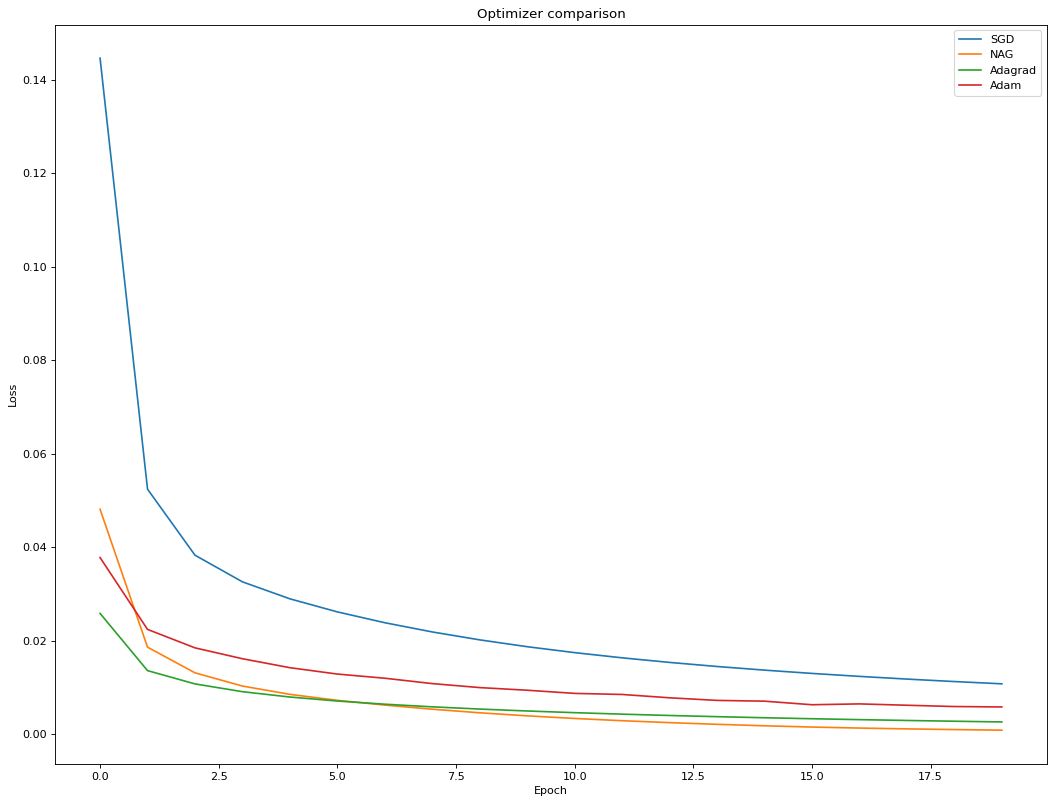

In [11]:
plt.figure(figsize=(16, 12), dpi=80)

plt.plot(np.c_[losses[0], losses[1], losses[2], losses[3]], label=labels)
plt.title("Optimizer comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Генетический алгоритм

In [39]:
import random
import numpy as np
from typing import List
from tqdm import tqdm

class Pop_Specimen:
    def __init__(self, layer_sizes: List[int]):
        self.layer_sizes = layer_sizes

    def get_fitness_score(self, **kwargs):
        mlp = MLP(input_size=784, layer_sizes=self.layer_sizes, output_size=10, batch_size=64)
        _ = mlp.fit(X_train, y_train, optimization_method='SGD', epochs=1, debug=False, lr=0.1)
        
        prediction = mlp.predict(X_test)
        true_res = np.argmax(y_test, axis=1)
        fitness = np.mean(prediction == true_res)
        return fitness

    @classmethod
    def create_random(cls, max_lsize: int = 200, max_lamount: int = 5):
        num_layers = random.randint(1, max_lamount)
        return cls([random.randint(1, max_lsize) for _ in range(num_layers)])

    def __repr__(self) -> str:
        return f"Sp({self.layer_sizes})"


def mutation(item: Pop_Specimen) -> Pop_Specimen:
    layer_sizes = item.layer_sizes.copy()
    mut_layer = random.choice(layer_sizes)
    mut_layer += random.randint(-50, 50)

    if len(layer_sizes) > 1:
        if random.random() < 0.5:
            layer_sizes.pop(random.randint(0, len(layer_sizes)-1))

    if random.random() < 0.5:
        layer_sizes.insert(random.randint(0, len(layer_sizes)-1), random.randint(1, 100))

    for i in range(len(layer_sizes)):
        if layer_sizes[i] < 1:
            layer_sizes[i] = random.randint(1, 50)
    return Pop_Specimen(layer_sizes)


def crossover(parent1: Pop_Specimen, parent2: Pop_Specimen) -> Pop_Specimen:
    n = len(parent1.layer_sizes)
    m = len(parent2.layer_sizes)
    layers_num = random.choice([min(n, m), (n + m)//2])
    new_layer_sizes = []

    if layers_num == 1:
        new_layer_sizes = [(parent1.layer_sizes[0] + parent2.layer_sizes[0])//2]
    else:
        for i in range(layers_num):
            if n <= i:
                new_layer_sizes.append(parent2.layer_sizes[i])
            elif m <= i:
                new_layer_sizes.append(parent1.layer_sizes[i])
            else:
                new_layer_sizes.append(random.choice([parent1.layer_sizes[i], parent2.layer_sizes[i], parent1.layer_sizes[0] + parent2.layer_sizes[0]//2]))

    return Pop_Specimen(new_layer_sizes)


def genetic_algorithm(
    pop_size: int, num_gens: int, select_num: int, crossbreed_p: float, mutation_p: float,
    train_data, train_labels, test_data, test_labels,
):
    pop = []
    for _ in range(pop_size):
        pop.append((Pop_Specimen.create_random(), None))

    fitnesses_history = []
    for _ in tqdm(range(num_gens)):
        fitness_scores = []
        for (item, score) in pop:
            fitness = score
            if score is None:
                fitness = item.get_fitness_score(X_train=train_data, y_train=train_labels, X_test=test_data, y_test=test_labels, debug=False)
            fitness_scores.append(fitness)
        fitnesses_history.append(fitness_scores)
        
        pop_fitness = [(pop[i][0], fitness_scores[i]) for i in range(len(fitness_scores))]
        print(sorted(pop_fitness, key=lambda x: x[1]))
        print('Max fitness:', max(fitness_scores))
        new_pop_wfitness = sorted(pop_fitness, key=lambda x: x[1])[-select_num:]
        
        children = []
        for i in range(pop_size-select_num):
            if random.random()<crossbreed_p:
                parent1, parent2 = random.choices([i[0] for i in new_pop_wfitness], weights=[i[1] for i in new_pop_wfitness], k=2)
                children.append(crossover(parent1, parent2))
            else:
                children.append(Pop_Specimen.create_random())

        for i in range(len(children)):
            if random.random() < mutation_p:
                children[i] = mutation(children[i])

        pop = new_pop_wfitness+[(i, None) for i in children]
            

    best_specimen = max(
        pop_fitness,
        key=lambda x: x[1]
    )
    return best_specimen, fitnesses_history

In [40]:
best_specimen, fitnesses_history = genetic_algorithm(
    20, 10, 10, 0.4, 0.2,
    X_train, y_train, X_test, y_test
)

 10%|█         | 1/10 [01:57<17:37, 117.51s/it]

[(Sp([3, 149, 194, 89, 126]), 0.0982), (Sp([154, 8, 171, 146, 192]), 0.0982), (Sp([122, 149, 76, 43]), 0.1028), (Sp([11, 164, 126, 41]), 0.1028), (Sp([162, 109, 112, 77]), 0.1028), (Sp([181, 124, 81, 77]), 0.1028), (Sp([59, 105, 151, 7]), 0.1028), (Sp([191, 2]), 0.2349), (Sp([125, 200, 144]), 0.4196), (Sp([90, 128, 86]), 0.4568), (Sp([189, 140, 103]), 0.4579), (Sp([134, 97, 60]), 0.4645), (Sp([37, 29]), 0.7479), (Sp([67, 39]), 0.7992), (Sp([179, 158]), 0.8201), (Sp([184, 156]), 0.8271), (Sp([153]), 0.8902), (Sp([44]), 0.8915), (Sp([122]), 0.8922), (Sp([83]), 0.8923)]
Max fitness: 0.8923


 20%|██        | 2/10 [02:48<10:25, 78.22s/it] 

[(Sp([179, 118, 188, 170]), 0.0982), (Sp([138, 147, 43, 154]), 0.0982), (Sp([94, 121, 167, 27]), 0.1028), (Sp([43, 117, 87, 123, 108]), 0.1028), (Sp([189, 140, 103]), 0.4579), (Sp([134, 97, 60]), 0.4645), (Sp([11, 31]), 0.7139), (Sp([37, 29]), 0.7479), (Sp([67, 39]), 0.7992), (Sp([179, 158]), 0.8201), (Sp([184, 156]), 0.8271), (Sp([189, 140]), 0.8329), (Sp([35, 173]), 0.8365), (Sp([60]), 0.8899), (Sp([153]), 0.8902), (Sp([104]), 0.891), (Sp([140]), 0.8913), (Sp([44]), 0.8915), (Sp([122]), 0.8922), (Sp([83]), 0.8923)]
Max fitness: 0.8923


 30%|███       | 3/10 [03:11<06:12, 53.15s/it]

[(Sp([158, 19, 72, 122]), 0.0982), (Sp([144, 74, 41, 154, 121]), 0.0982), (Sp([46, 155, 120, 132, 59]), 0.1028), (Sp([52, 147, 144]), 0.4431), (Sp([139, 107]), 0.8238), (Sp([184, 156]), 0.8271), (Sp([189, 140]), 0.8329), (Sp([35, 173]), 0.8365), (Sp([168]), 0.8893), (Sp([60]), 0.8899), (Sp([153]), 0.8902), (Sp([126]), 0.8902), (Sp([122]), 0.8906), (Sp([104]), 0.891), (Sp([140]), 0.8913), (Sp([44]), 0.8915), (Sp([153]), 0.8918), (Sp([122]), 0.8922), (Sp([83]), 0.8923), (Sp([91]), 0.8925)]
Max fitness: 0.8925


 40%|████      | 4/10 [03:31<03:59, 39.90s/it]

[(Sp([34, 46, 110, 130]), 0.0982), (Sp([139, 47, 131, 141, 82]), 0.1028), (Sp([87, 168, 8, 192, 61]), 0.1028), (Sp([61, 90, 83]), 0.4508), (Sp([35, 85]), 0.8039), (Sp([150, 169]), 0.8296), (Sp([19]), 0.8771), (Sp([153]), 0.8902), (Sp([126]), 0.8902), (Sp([128]), 0.8904), (Sp([122]), 0.8906), (Sp([104]), 0.891), (Sp([140]), 0.8913), (Sp([44]), 0.8915), (Sp([137]), 0.8916), (Sp([153]), 0.8918), (Sp([122]), 0.8922), (Sp([146]), 0.8922), (Sp([83]), 0.8923), (Sp([91]), 0.8925)]
Max fitness: 0.8925


 50%|█████     | 5/10 [03:51<02:45, 33.00s/it]

[(Sp([160, 104, 90, 152]), 0.0982), (Sp([113, 89, 138, 85]), 0.1028), (Sp([111, 16, 195]), 0.436), (Sp([6, 129]), 0.8095), (Sp([29, 114]), 0.8227), (Sp([146, 182]), 0.827), (Sp([138, 194]), 0.8297), (Sp([131]), 0.8886), (Sp([137]), 0.89), (Sp([122]), 0.8906), (Sp([97]), 0.8908), (Sp([104]), 0.891), (Sp([140]), 0.8913), (Sp([44]), 0.8915), (Sp([137]), 0.8916), (Sp([153]), 0.8918), (Sp([122]), 0.8922), (Sp([146]), 0.8922), (Sp([83]), 0.8923), (Sp([91]), 0.8925)]
Max fitness: 0.8925


 60%|██████    | 6/10 [04:12<01:54, 28.74s/it]

[(Sp([126, 141, 122, 61, 120]), 0.0982), (Sp([47, 20, 91]), 0.3912), (Sp([136, 45, 99]), 0.4051), (Sp([69, 70, 134]), 0.4136), (Sp([54, 27]), 0.7724), (Sp([175, 190]), 0.8251), (Sp([68, 171]), 0.8286), (Sp([97]), 0.8908), (Sp([104]), 0.891), (Sp([140]), 0.8913), (Sp([44]), 0.8915), (Sp([137]), 0.8916), (Sp([153]), 0.8918), (Sp([141]), 0.892), (Sp([122]), 0.8922), (Sp([146]), 0.8922), (Sp([83]), 0.8923), (Sp([93]), 0.8924), (Sp([118]), 0.8924), (Sp([91]), 0.8925)]
Max fitness: 0.8925


 70%|███████   | 7/10 [04:34<01:20, 26.68s/it]

[(Sp([168, 124, 51, 134]), 0.0982), (Sp([74, 187, 129, 12]), 0.1028), (Sp([92, 200, 102]), 0.3713), (Sp([152, 131, 18]), 0.4299), (Sp([145, 32]), 0.7874), (Sp([193]), 0.8887), (Sp([44]), 0.8915), (Sp([156]), 0.8915), (Sp([137]), 0.8916), (Sp([153]), 0.8918), (Sp([141]), 0.892), (Sp([98]), 0.8921), (Sp([122]), 0.8922), (Sp([146]), 0.8922), (Sp([83]), 0.8923), (Sp([93]), 0.8924), (Sp([118]), 0.8924), (Sp([91]), 0.8925), (Sp([114]), 0.8927), (Sp([100]), 0.8943)]
Max fitness: 0.8943


 80%|████████  | 8/10 [04:53<00:48, 24.28s/it]

[(Sp([178, 115, 33, 110, 114]), 0.0982), (Sp([146, 4, 8, 98, 122]), 0.0982), (Sp([106, 49, 5]), 0.23), (Sp([65, 77]), 0.7974), (Sp([120]), 0.8894), (Sp([132]), 0.8902), (Sp([112]), 0.8911), (Sp([141]), 0.892), (Sp([98]), 0.8921), (Sp([80]), 0.8921), (Sp([122]), 0.8922), (Sp([146]), 0.8922), (Sp([83]), 0.8923), (Sp([93]), 0.8924), (Sp([118]), 0.8924), (Sp([116]), 0.8924), (Sp([91]), 0.8925), (Sp([114]), 0.8927), (Sp([89]), 0.8927), (Sp([100]), 0.8943)]
Max fitness: 0.8943


 90%|█████████ | 9/10 [05:16<00:23, 23.80s/it]

[(Sp([127, 113, 166, 2, 189]), 0.0982), (Sp([67, 9, 106, 113, 2]), 0.1028), (Sp([164, 122, 94, 19]), 0.1028), (Sp([141, 185, 125]), 0.4196), (Sp([194, 118, 158]), 0.4314), (Sp([117]), 0.8904), (Sp([116]), 0.8918), (Sp([101]), 0.8918), (Sp([122]), 0.8922), (Sp([146]), 0.8922), (Sp([83]), 0.8923), (Sp([93]), 0.8924), (Sp([118]), 0.8924), (Sp([116]), 0.8924), (Sp([91]), 0.8925), (Sp([114]), 0.8927), (Sp([89]), 0.8927), (Sp([96]), 0.8927), (Sp([58]), 0.8942), (Sp([100]), 0.8943)]
Max fitness: 0.8943


100%|██████████| 10/10 [05:31<00:00, 33.18s/it]

[(Sp([74, 63, 144, 148]), 0.0982), (Sp([44, 3, 32, 185]), 0.0982), (Sp([1, 143, 91, 151, 42]), 0.1028), (Sp([7, 105]), 0.771), (Sp([74, 162]), 0.8295), (Sp([103]), 0.8905), (Sp([117]), 0.8916), (Sp([56]), 0.8916), (Sp([83]), 0.8923), (Sp([93]), 0.8924), (Sp([118]), 0.8924), (Sp([116]), 0.8924), (Sp([91]), 0.8925), (Sp([114]), 0.8927), (Sp([89]), 0.8927), (Sp([96]), 0.8927), (Sp([107]), 0.8932), (Sp([58]), 0.8942), (Sp([77]), 0.8942), (Sp([100]), 0.8943)]
Max fitness: 0.8943


In [41]:
best_specimen

(Sp([100]), 0.8943)

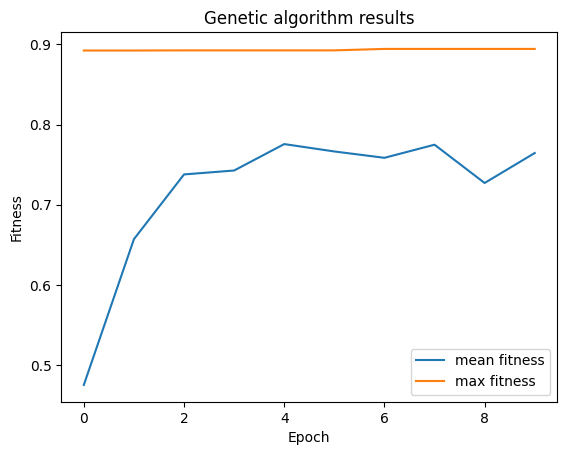

In [42]:
plt.plot([sum(m)/len(m) for m in fitnesses_history])
plt.plot([max(m) for m in fitnesses_history])
plt.legend(['mean fitness', 'max fitness'])
plt.title("Genetic algorithm results")
plt.xlabel("Epoch")
plt.ylabel("Fitness")
plt.show()